# Imports

In [2]:
%matplotlib inline

import pandas as pd
from datetime import datetime
from IPython.display import Image, HTML
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import arcgis 
from arcgis.gis import GIS
from arcgis.raster import Raster
from arcgis.learn import MLModel, prepare_tabulardata
from arcgis.raster.functions import apply, clip, remap, colormap
from fastai.vision import *

from arcgis.raster.functions import *

# Busqueda de las imágenes

In [3]:
gis = GIS("https://www.arcgis.com",'usuario','clave')

<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>
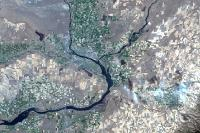

In [4]:
s2 = gis.content.get('fd61b9e0c69c4e14bebd50a9a968348c')
sentinel = s2.layers[0]
s2

In [33]:
#Define aoi extent
amazon_extent = {'SpatialReference': {'latestWkid': 3857, 'wkid': 102100},
                                         'type': 'extent',
                                         'xmin': -8054318.827199999,
                                         'xmax': -8047083.983100001,
                                         'ymax': 221448.8702000007,
                                         'ymin': 215209.32550000027}


In [38]:
#filter the images
selected = sentinel.filter_by(where ="(Category = 1)",
                             geometry = arcgis.geometry.filters.intersects(amazon_extent))
df = selected.query(out_fields="AcquisitionDate,Name, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['acquisitiondate'],unit='ms')
df = df[df['cloudcover']<0.1]
df

,objectid,acquisitiondate,name,groupname,cloudcover,dayofyear,SHAPE,AcquisitionDate
9,1708179,2020-06-09 15:22:47,20200609T152246_18NXG_0,20200609T152246_18NXG_0,0.0968,161,"{""rings"": [[[-8139313.2508000005, 201090.96480...",2020-06-09 15:22:47
25,449897,2020-08-28 15:22:48,20200828T152247_18NXG_0,20200828T152247_18NXG_0,0.0828,241,"{""rings"": [[[-8139313.2508000005, 201090.96480...",2020-08-28 15:22:48
27,372561,2020-09-07 15:22:47,20200907T152247_18NXG_0,20200907T152247_18NXG_0,0.0049,251,"{""rings"": [[[-8139313.2508000005, 201090.96480...",2020-09-07 15:22:47
28,907058,2020-09-12 15:22:49,20200912T152248_18NXG_0,20200912T152248_18NXG_0,0.0209,256,"{""rings"": [[[-8139313.2508000005, 201090.96480...",2020-09-12 15:22:49
29,105658,2020-09-17 15:22:46,20200917T152246_18NXG_0,20200917T152246_18NXG_0,0.0005,261,"{""rings"": [[[-8139313.2508000005, 201090.96480...",2020-09-17 15:22:46
52,1762793,2021-01-15 15:22:44,20210115T152244_18NXG_0,20210115T152244_18NXG_0,0.0002,15,"{""rings"": [[[-8139313.2508000005, 201090.96480...",2021-01-15 15:22:44
55,4257957,2021-01-30 15:22:45,20210130T152244_18NXG_0,20210130T152244_18NXG_0,0.0005,30,"{""rings"": [[[-8139333.8398, 173603.0053000003]...",2021-01-30 15:22:45
65,4268720,2021-03-21 15:22:43,20210321T152243_18NXG_0,20210321T152243_18NXG_0,0.0210,80,"{""rings"": [[[-8139333.8398, 173603.0053000003]...",2021-03-21 15:22:43


# Modelo

## Importar datos de entrenamiento

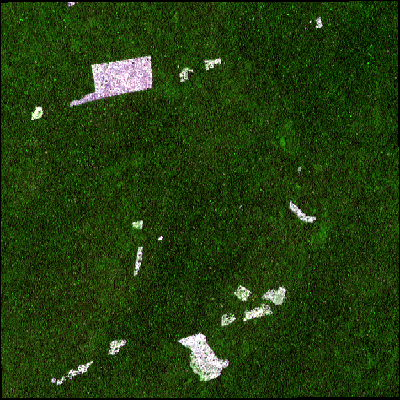

In [23]:
Image = Raster(r'images/deforestation/image_comp.tif')
Image

## Preparar datos de entrenamiento

In [43]:
preprocessors = [('image_comp.tif','image_comp.tif_1','image_comp.tif_2','image_comp.tif_3',MinMaxScaler())]

In [44]:
data = prepare_tabulardata(explanatory_rasters=[Image],preprocessors=preprocessors)

In [45]:
data.show_batch()

,image_comp.tif,image_comp.tif_1,image_comp.tif_2,image_comp.tif_3
53508,860,768,451,2666
179532,866,730,462,2506
209281,848,720,417,2476
321933,851,742,433,2507
397043,861,761,448,2702


## Creación del modelo

In [46]:
model = MLModel(data,'sklearn.cluster.KMeans',n_clusters = 3,init='k-means++',random_state=123)

## Entrenamiento del Modelo

Cluster: [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans)

In [47]:
model.fit()

In [48]:
model.show_results()

,image_comp.tif,image_comp.tif_1,image_comp.tif_2,image_comp.tif_3,prediction_results
88933,867,758,447,2721,0
160878,844,716,415,2647,0
261781,856,737,420,2696,0
386101,874,814,455,3200,0
440498,846,714,412,2602,0


# Predicción

In [50]:
pred_new = model.predict(explanatory_rasters=[Image], prediction_type='raster',output_raster_path=r'images/deforestation/results.tif')

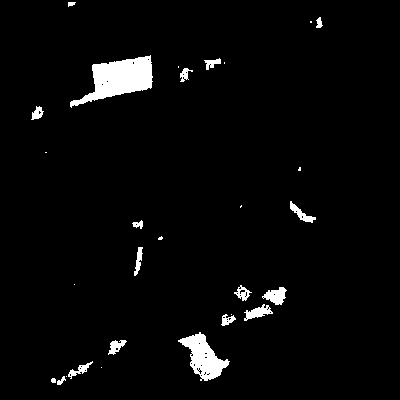

In [52]:
Raster(r'images/deforestation/results.tif')